In [95]:
import numpy as np
import matplotlib.pyplot as plt
xc = [0.5, 0.5]

def g(x):
    if (x[0] > 1 or x[0] < 0 or x[1] > 1 or x[1] < 0) :
        return 0
    return 1 - 4*np.exp(-10*np.linalg.norm(np.subtract(x, xc)))

# i = y, j = x, for M matrix!
def iToC(i, j, dim):
    return (i/dim, j/dim)

# i = y, j = x
def getGValDir(i, j, dim, direc):
    res = []
    if ("n" in direc):
        res.append(g(iToC(i + 1, j, dim)))
    if ("e" in direc):
        res.append(g(iToC(i, j + 1, dim)))
    if ("s" in direc):
        res.append(g(iToC(i - 1, j, dim)))
    if ("w" in direc):
        res.append(g(iToC(i, j - 1, dim)))
    return res

def gs(i, j, dim):
    x, y = iToC(i, j, dim)

def initGMatrix(dim):
    G = np.zeros((dim*dim, 4))
    # N -> E -> S -> W
    for i in range(0, dim*dim):
        ycord = i // dim
        xcord = i % dim
        
    
#Remember! S[y][x]
def initS(dim, kappa):
    h = 1/dim
    S = np.zeros((dim*dim, dim*dim))
    
    #initialize top left
    #set the corner values
    S[0][0] = 0 # (-ge-gn)/2 - hk
    S[dim-1][dim-1] = 0 # (-gw-gn)/2 - hk
    
    #set the corner values of the matrix to the right
    S[0][dim] = 0 #gn/2
    
    S[dim-1][dim+dim-1] = 0 #gn/2
    
    for i in range(0, dim - 2):
        #set the diag values in both sub-matrices
        S[i+1][i+1] = 0 #-gn - (ge+gn)/2 - hk
        S[i+1][dim+i+1] = 0 #gn
        
    for i in range(0, dim - 1):
        #set the values of the second diagonals in the diag sub-matrix
        S[i][i+1] = 0 #ge/2
        S[i+1][i] = 0 #gw/2
        
    #initialize bot right
    #set the corner values
    S[dim*(dim-1)][dim*(dim-1)] = 7 #(-ge-gs)/2 - hk
    
    S[dim*dim-1][dim*dim-1] = 8 #(-gw-gs)/2 - hk
    
    #set the corner values of the matrix to the left
    S[dim*(dim-1)][(dim-1)*(dim-1)-1] = S[dim*dim-1][dim*(dim-1)-1]= 9 #gs/2
    for i in range(0, dim - 2):
        #set the diag values in both sub-matrices
        S[dim*(dim-1)+1+i][dim*(dim-1)+1+i] = 1 #-gs-(ge+gw)/2-hk
        S[dim*(dim-1)+1+i][(dim-1)*(dim-1)+i] = 2 #gs
    for i in range(0, dim - 1):
        #set the values of the second diagonals in the diag sub-matrix
        S[dim*(dim-1)+i][dim*(dim-1)+1+i] = 3 #ge/2
        S[dim*(dim-1)+1+i][dim*(dim-1)+i] = 4 #gw/2
        
    #initialize middle
    for i in range(0, dim - 2):
        for j in range(0, dim):
            S[(i+1)*dim+j][i*dim+j] = 5 #gs
            S[(i+1)*dim+j][(i+2)*dim+j] = 3 #gn
        S[(i+1)*dim][(i+1)*dim] = 2 #-ge-(gs+gn)/2-hk
        S[(i+2)*dim-1][(i+2)*dim-1] = 3 #-gw-(gs+gn)/2-hk
        for j in range(0, dim - 2):
            S[(i+1)*dim+j+1][(i+1)*dim+j+1] = 8 #-ge-gn-gw-gs
        for j in range(0, dim - 1):
            S[(i+1)*dim+j][(i+1)*dim+j+1] = 4 #ge
            S[(i+1)*dim+j+1][(i+1)*dim+j] = 2 #gw
    return S

#print(initS(10, 1))
#plt.spy(initS(6))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 3. 0.]
 [0. 0. 0. ... 4. 1. 3.]
 [0. 0. 0. ... 0. 4. 8.]]


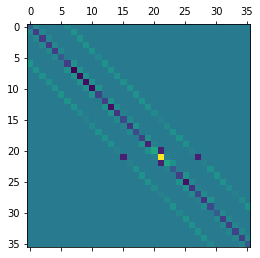

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
xc = [0.5, 0.5]

def g(x):
    if (x[0] > 1 or x[0] < 0 or x[1] > 1 or x[1] < 0) :
        return 0
    return 1 - 4*np.exp(-10*np.linalg.norm(np.subtract(x, xc)))

#i = y, j = x
def iStoC(i, j, dim):
        xcord = (j % dim) / dim
        ycord = (i // dim) / dim
        return (xcord, ycord)

#S[y][x]
def initS(n, kappa):
    S = np.zeros((n*n, n*n))
    h = 1/n
    for i in range(n*n):
        if (i < n):
            gn = g(iStoC(i+1, i, n))
            ge = g(iStoC(i, i+1, n))
            gw = g(iStoC(i, i-1, n))
            if (i == 0):
                S[i][i] = -(ge+gn)/2-h*kappa
                S[i][i+1] = ge/2
                S[i][i+n] = gn/2
            elif(i == n - 1):
                S[i][i] = -(gw+gn)/2-h*kappa
                S[i][i-1] = gw/2
                S[i][i+n] = gn/2
            else:
                S[i][i] = -gn-(ge+gw)/2-h*kappa
                S[i][i-1] = gw/2
                S[i][i+1] = ge/2
                S[i][i+n] = gn
                
        if (i >= n*(n-1)):
            ge = g(iStoC(i, i+1, n))
            gs = g(iStoC(i-1, i, n))
            gw = g(iStoC(i, i-1, n))
            if (i % n == 0):
                S[i][i] = -(ge+gs)/2-h*kappa
                S[i][i+1] = ge/2
                S[i][i-n] = gs/2
            elif ((i + 1) % n == 0):
                S[i][i] = -(gw+gs)/2-h*kappa
                S[i][i-1] = gw/2
                S[i][i-n] = gs/2
            else:
                S[i][i] = -gs-(ge+gw)/2-h*kappa
                S[i][i-1] = gw/2
                S[i][i+1] = ge/2
                S[i][i-n] = gs
                
        if (n <= i < n*(n-1)):
            gn = g(iStoC(i+1, i, n))
            ge = g(iStoC(i, i+1, n))
            gs = g(iStoC(i-1, i, n))
            gw = g(iStoC(i, i-1, n))
            S[i][i-n] = gs
            S[i][i+n] = gn
            if (i % n == 0):
                S[i][i] = -ge-(gs+gn)/2-h*kappa
                S[i][i+1] = ge
            elif ((i + 1) % n == 0):
                S[i][i] = -gw -(gs+gn)/2-h*kappa
                S[i][i-1] = gw
            else:
                S[i][i] = -gn-ge-gs-gw
                S[i][i-1] = gw
                S[i][i+1] = ge
    return S

def init_M(dim):
    D = np.ones(dim)
    D[[0,-1]] = 0.5
    print(D)
    D = np.concatenate((0.5*D,np.tile(D,dim-2),0.5*D))
    M = np.diag(D)
    return M


#print(initS(4, 1))
# plt.spy(initS(6,1))
plt.matshow(initS(6,1))